In [ ]:
import pickle
from matplotlib.pyplot import *
from scipy import interpolate

%pylab inline

In [6]:
def load_obj(name ):
    if name[-4:]=='.pkl':
        name = name[:-4]
    #~ try:
        #~ return pk5.dumps(name+'pkl', protocol=5)
    #~ except:
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)
def save_obj(obj, name ):
    if name[-4:]=='.pkl':
        name = name[:-4]
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Load Opsin data

In [7]:
fsave = './PhotoReceptorData'
PhData = load_obj(fsave)                        # Photo Receptors Data

Opsins=[]                                       # Opsins matrix initialization

Opsins.append(PhData['Scones'])                 # S cones
Opsins.append(PhData['Mela'])                   # Melanopsin
Opsins.append(PhData['Rods'])                   # Rods
Opsins.append(PhData['Mcones'])                 # M cones
Opsins.append(PhData['RedOpsin'])               # Red Opsin

x = PhData['x_axis']                            # Wavelength axis

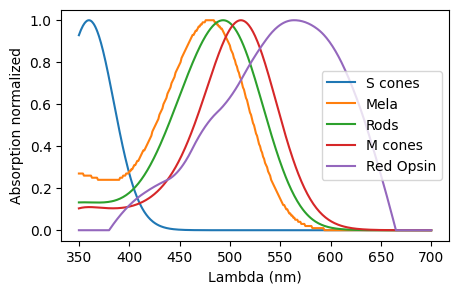

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))

for o in Opsins:
    ax.plot(x,o)

ax.set_xlabel('Lambda (nm)')    
ax.set_ylabel('Absorption normalized')
ax.legend(['S cones','Mela','Rods','M cones','Red Opsin'])

# Load LEDs illumination Data

In [9]:
fsave = './IlluminationDataMEA2'
IData = load_obj(fsave)                                     # Illumination Data Load

LEDs =[]                                                    # LEDs matrix initialization                                
LEDs.append(IData['Violet'])                                # Violet        
LEDs.append(IData['Blue'])                                  # Blue
LEDs.append(IData['Green'])                                 # Green
LEDs.append(IData['Yellow'])                                # Yellow
LEDs.append(IData['Red'])                                   # Red

x = IData['x_axis']                                         # Wavelength axis

# Power meter correction factor from 09/09/22
correction_f = 14.5                                         # Correction factor due to ??????????????????????????????????????????????????????????????????????????

LEDs=np.array(LEDs)/correction_f                            # Correction

Text(0, 0.5, 'Power (µW/cm²)')

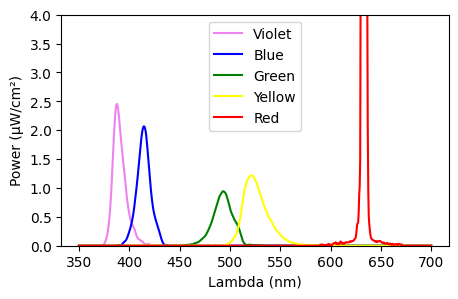

In [10]:
fig , ax = plt.subplots(figsize=(5, 3))

ax.plot(x,LEDs[0], 'violet')
ax.plot(x,LEDs[1], 'blue')
ax.plot(x,LEDs[2], 'green')
ax.plot(x,LEDs[3], 'yellow')
ax.plot(x,LEDs[4], 'red')

ax.legend(['Violet','Blue','Green','Yellow','Red'])

ax.set_ylim([0,4])
ax.set_xlabel('Lambda (nm)')
ax.set_ylabel('Power (µW/cm²)')


# Calculate Isomerizations

## Functions

In [12]:
def IlluminanceFactor(Amp1,AmpPhoto,wl):   
    """""
    Main function that gets: 
    1 - the light amplitude not normalized in µW/cm²                                    ?????????????????????????????????????????????????????????????????????????????????????????????????????/
    2 - the spectra of the target opsin normalized to 1 at the peak (a.u.)
    3 - the wavelength step (nm)

    Factors have units of:
    ac = µm²
    hc = J.m
    10**23 puts all in µW - µm² 

    Output is in isomerizations / s

    To get the result in photons/cm^2/s we have to multiply by 10^8 and divide by ac (x5 or x2 for rods)
    """""
    # Amplitude 1 is the LED source normalized to have the integral equal to the total power. 
    # Amp photo is the Spectral curve of the photoreceptor (all 4 together)
    # wl is the steps in lambda for the curves
    # Gives back the result of each photoreceptor
    
    #Illuminance Factor Product hyperparameters
    h=6.63*10**(-34)                    # Planck constant J.s
    c=299792458                         # speed of light [m/s]  
    
    ac=[0.2,0.2,0.5,0.2,0.2]            # en µm²
    # ac_cones=0.2
    # ac_rods=0.5
    # ac_mela=0.2
    # ac_reach=0.2
    
    IlluminanceFactor=[]
    for photo in range(len(AmpPhoto)):
        IlFa=0
        for I_wl in range(len(Amp1)):
            # Results in photoisomerisation/s /µm²
            IlFa+= Amp1[I_wl] * AmpPhoto[photo][I_wl] * wl[I_wl] * diff(wl)[10]  * ac[photo]/(h*c) *10**(-23) 
                    #µW/cm²   x   a.u.(peak at 1)    x nm (lambda) x lambda step x ph.µm² x 1/(Jm)  x convert to same units
        IlluminanceFactor.append(IlFa) 
    return np.array(IlluminanceFactor) #

def Write_fancy(result,F):
    o_names = ['Scones    ','Melanopsin','Rhodopsin ','Mcones    ','Red_opsin ']
    for i,r in enumerate(result):
        if F=='scientific':
            print(o_names[i],' :',"{:.2e}".format(r))
        else:
             print(o_names[i],' :',"{:10.0f}".format(r))

## Compute Isomerization for all opsins for all LEDs sources

In [29]:
# Get effect from Violet

ISO_result = IlluminanceFactor(LEDs[0],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :      63894
Melanopsin  :      34445
Rhodopsin   :      52541
Mcones      :      14589
Red_opsin   :       9179

Scones      : 6.39e+04
Melanopsin  : 3.44e+04
Rhodopsin   : 5.25e+04
Mcones      : 1.46e+04
Red_opsin   : 9.18e+03


In [30]:
# Get effect from Blue

ISO_result = IlluminanceFactor(LEDs[1],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :      14331
Melanopsin  :      53248
Rhodopsin   :      91382
Mcones      :      19465
Red_opsin   :      24037

Scones      : 1.43e+04
Melanopsin  : 5.32e+04
Rhodopsin   : 9.14e+04
Mcones      : 1.95e+04
Red_opsin   : 2.40e+04


In [31]:
# Get effect from Green

ISO_result = IlluminanceFactor(LEDs[2],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :          4
Melanopsin  :     100325
Rhodopsin   :     265848
Mcones      :      95022
Red_opsin   :      64960

Scones      : 4.49e+00
Melanopsin  : 1.00e+05
Rhodopsin   : 2.66e+05
Mcones      : 9.50e+04
Red_opsin   : 6.50e+04


In [32]:
# Get effect from Yellow

ISO_result = IlluminanceFactor(LEDs[3],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :          0
Melanopsin  :      83945
Rhodopsin   :     307509
Mcones      :     156047
Red_opsin   :     150925

Scones      : 2.03e-01
Melanopsin  : 8.39e+04
Rhodopsin   : 3.08e+05
Mcones      : 1.56e+05
Red_opsin   : 1.51e+05


In [33]:
# Get effect from RED

ISO_result = IlluminanceFactor(LEDs[4],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :          0
Melanopsin  :          3
Rhodopsin   :       4007
Mcones      :       8129
Red_opsin   :    1073043

Scones      : 5.85e-05
Melanopsin  : 2.65e+00
Rhodopsin   : 4.01e+03
Mcones      : 8.13e+03
Red_opsin   : 1.07e+06


In [34]:
# Get effect from All together

ISO_result = IlluminanceFactor(np.sum(LEDs[0:4],axis=0),Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :      78230
Melanopsin  :     271962
Rhodopsin   :     717280
Mcones      :     285122
Red_opsin   :     249100

Scones      : 7.82e+04
Melanopsin  : 2.72e+05
Rhodopsin   : 7.17e+05
Mcones      : 2.85e+05
Red_opsin   : 2.49e+05


## Repeat for (Human) White Light Illumination


25.000000000000007

<Figure size 640x480 with 0 Axes>

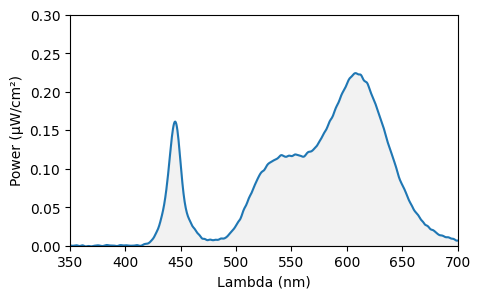

In [50]:
# Load LED data (for white in this case)
file_cal = 'cal_with_MEA2_matias.pkl'
caldata =load_obj(file_cal)

lx = caldata['xnew']
lx[0] = 300

color_order = caldata['orderS']
spec_curves = np.array(caldata['LedSpectra'])
spec_curves[:,0]=0


#--------------------------------------------------------------------------------
# White Spec for Vis Stim
figure()
WhiteVisPower = 25

WhiteVS = spec_curves[5]/np.sum(spec_curves[5])/diff(lx)[10]  * WhiteVisPower

f = interpolate.interp1d(lx,WhiteVS)
newWvis = f(x)/np.sum(f(x))*np.sum(WhiteVS)*diff(lx)[10]/diff(x)[0]

fig , ax = plt.subplots(figsize=(5, 3))

ax.plot(x,newWvis)
ax.fill_between(x,0,newWvis,alpha=0.1, color='grey')

ax.set_xlim([350,700])
ax.set_ylim([0,0.3])
ax.set_xlabel('Lambda (nm)')
ax.set_ylabel('Power (µW/cm²)')

np.sum(newWvis)*diff(x)[10]

In [51]:
# Get effect from White at Vis stim in 2p Setup

ISO_result = IlluminanceFactor(newWvis,Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :         89
Melanopsin  :      22069
Rhodopsin   :      69974
Mcones      :      33646
Red_opsin   :     102293

Scones      : 8.85e+01
Melanopsin  : 2.21e+04
Rhodopsin   : 7.00e+04
Mcones      : 3.36e+04
Red_opsin   : 1.02e+05


In [52]:
# Get effect from White at OPTO full field

WhiteOptoPower = 71900/correction_f
ISO_result = IlluminanceFactor(newWvis/np.sum(newWvis)*WhiteOptoPower/diff(x)[10],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')

print('')
# For Chrimson activation -> photons / cm2 / s -> *10^8 /ac  (=*5)
print('For photons / cm / s')
Write_fancy(ISO_result*10**8*5,F='scientific')

Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :      17556
Melanopsin  :    4377327
Rhodopsin   :   13879002
Mcones      :    6673596
Red_opsin   :   20289293

Scones      : 1.76e+04
Melanopsin  : 4.38e+06
Rhodopsin   : 1.39e+07
Mcones      : 6.67e+06
Red_opsin   : 2.03e+07

For photons / cm / s
Scones      : 8.78e+12
Melanopsin  : 2.19e+15
Rhodopsin   : 6.94e+15
Mcones      : 3.34e+15
Red_opsin   : 1.01e+16


# Get Here my own result

In [ ]:
def ExtractSpectData(f,skiplines=16):
    data=[]
    with open(f ,'r') as file:
        count=0
        data = []
        for readline in file: 
            count+=1
            if count>skiplines:
                line_strip = readline.strip()
                data.append(line_strip.split('\t'))
    data=np.array(data).astype('float')
    return np.array(data)

#-------------------------------------------------------------------------------------
# Load your light source normalized to have the area beneath the curve equal to the total power
# (take into account that our x coordinate has a step of 0.5)
##############################
rootf = '/home'
myfile = rootf + '/matias/Dropbox/Drop-IdV/PROJECTS/COLORS/EXPS_AND_CALIBRATIONS/MEA2_calibration/spectra_white_USB2H153121_17-13-59-331.txt'
white = ExtractSpectData(myfile)

bfile = './background_MEA2'
bckgnd = load_obj(bfile)
##############################

#----------------------------------------
# Substracting background
White=white
White[:,1]=white[:,1]-bckgnd[:]

#Putting at 0 the curve

White[:,1]=White[:,1]-np.min(White[1000:,1])
# print(np.mean(White[:,1]))

# Get proper x axis

xnew = np.linspace(350,700,701)
lx = White[:,0]

f = interpolate.interp1d(lx,White[:,1])
newWhite = f(xnew)/np.sum(f(xnew))*np.sum(White[:,1])*diff(lx)[10]/diff(xnew)[0]   # use interpolation function returned by `interp1d`

##############################
# Measured Power (uW/cm^2)
correct_factor_mea2 = 55.7
P=61400/correct_factor_mea2
##############################
newWhite = newWhite/np.sum(newWhite)*P/diff(x)[0]   #remember to divide by binsize

#----------------------------------------
# plot light specturm
plot(x,newWhite)
ylim(bottom=0)
# -----------------------------------------

In [ ]:

# my_light = load_obj(myfile)
my_light = newWhite

ISO_result = IlluminanceFactor(my_light,Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


# Reasoning: building (Mouse) White light illumination

## Summary



<p align = "center">
<img src="media/balancing_channels_reasoning.png" width="800">

</p>


## Computations

With current settings the green to violet ratio is : 0.5190


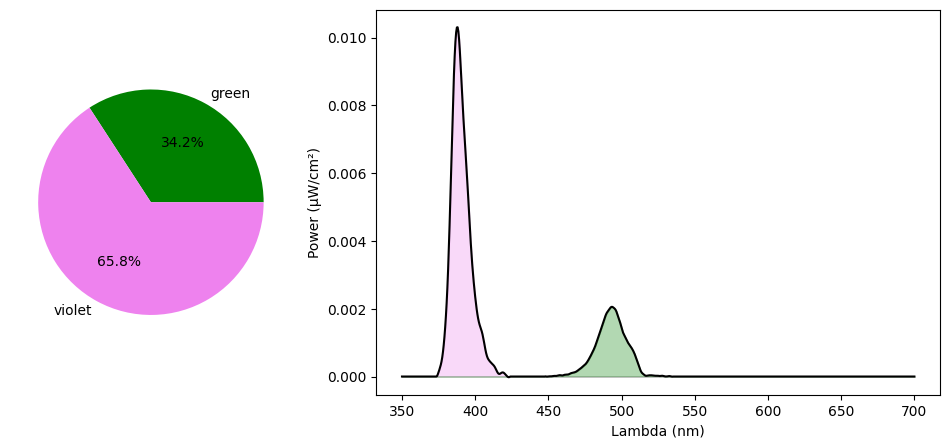

In [13]:
# Filippo
#----------------------------------------
violet = 0.0042
blue   = 0 
green  = 0.00218
yellow = 0
red    = 0

my_light = LEDs[0]*violet + LEDs[1]*blue + LEDs[2]*green + LEDs[3]*yellow + LEDs[4]*red
r = green/violet

print('With current settings the green to violet ratio is :' , "{:.4f}".format(r))

perc_green = green/(green+violet)
perc_violet = violet/(green+violet)

fig, ax = plt.subplots(figsize=(12, 5), ncols = 2, nrows = 1, gridspec_kw={'width_ratios': [1, 2]})

# pie plot 
pie_data = [perc_green,perc_violet]
labels = ['green','violet']
pie_colors = ['green','violet']

ax[0].pie(pie_data,labels=labels,autopct='%1.1f%%', colors=pie_colors)

ax[1].plot(x,my_light, 'k')
ax[1].set_xlabel('Lambda (nm)')
ax[1].set_ylabel('Power (µW/cm²)')
ax[1].fill_between(x,0,LEDs[0]*violet,alpha=0.3, color='violet')
ax[1].fill_between(x,0,LEDs[2]*green,alpha=0.3, color='green')
fig = plt.gcf()


In [14]:
NDfilter = 0
Transmission =  10**(-NDfilter/10)

LIGHT = (violet*LEDs[0]+blue*LEDs[1]+green*LEDs[2]+yellow*LEDs[3]+red*LEDs[4])*Transmission

ISO_result = IlluminanceFactor(LIGHT,Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')

Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :        268
Melanopsin  :        363
Rhodopsin   :        800
Mcones      :        268
Red_opsin   :        180

Scones      : 2.68e+02
Melanopsin  : 3.63e+02
Rhodopsin   : 8.00e+02
Mcones      : 2.68e+02
Red_opsin   : 1.80e+02


In [16]:
# Load LED data

file_cal = "cal_with_MEA2_matias.pkl"
caldata =load_obj(file_cal)
print(caldata.keys())

dict_keys(['V', 'Vcurves', 'xnew', 'LedSpectra', 'orderV', 'orderS', 'whiteP'])


In [17]:
lx = caldata['xnew']
lx[0] = 300

color_order = caldata['orderS']
spec_curves = np.array(caldata['LedSpectra'])
spec_curves[:,0]=0


reorder = [1,2,3,4,5]
Vcurves = np.array(caldata['Vcurves'])[:,reorder]

In [18]:
#---------------------------------------------
# New interpolated V calibration curves

Vnew = np.linspace(0,5,5001)
newVcurves = np.zeros([5,5001])
for i in np.arange(5):
    vals = (np. isnan(Vcurves[:,i]))==False
    f = interpolate.interp1d(caldata['V'][vals],Vcurves[:,i][vals],fill_value="extrapolate")
    newVcurves[i] = f(Vnew) / correction_f  # use interpolation function returned by `interp1d`
    newVcurves[i] = np.where(newVcurves[i]<0,0,newVcurves[i]) # take negative extrapolations out


Rmax = np.nanmax(newVcurves[0])
Ymax = np.nanmax(newVcurves[1])
Gmax = np.nanmax(newVcurves[2])
Bmax = np.nanmax(newVcurves[3])
Vmax = np.nanmax(newVcurves[4])

In [19]:
# Function that returns a voltage given a certain power value in percentage of max possible value  
def find_V(value,color):
    if color =='r':
            array = newVcurves[0]
            vmax=Rmax
    elif color== 'y':
            array = newVcurves[1]
            vmax=Ymax
    elif color== 'g':
            array = newVcurves[2]
            vmax=Gmax
    elif color== 'b':
            array = newVcurves[3]
            vmax=Bmax
    elif color== 'v':
            array = newVcurves[4]
            vmax=Vmax
    
    array = np.asarray(array)
    idx = (np.abs(array - value*vmax)).argmin()
    return Vnew[idx]
#==============


# 1/violet,1/green,Transmission
#Print voltages
print('\nVoltages')
print('redV   ',find_V(red,'r'),' V')
print('yellowV',find_V(yellow,'r'),' V')
print('greenV ',find_V(green,'r'),' V')
print('blueV  ',find_V(blue,'r'),' V')
print('violetV',find_V(violet,'r'),' V')



Voltages
redV    0.0  V
yellowV 0.0  V
greenV  0.029  V
blueV   0.0  V
violetV 0.035  V
